In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso,Ridge
from sklearn.metrics import mean_squared_error,r2_score,confusion_matrix,ConfusionMatrixDisplay,roc_curve,RocCurveDisplay,auc,precision_recall_fscore_support,precision_score
import joblib 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler,Binarizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from feature_engine.wrappers import SklearnTransformerWrapper as TransformerWrapper
from feature_engine.imputation import CategoricalImputer, MeanMedianImputer



In [2]:
data = pd.read_csv("candy-data.csv")

# remove competitorname feature 
data.drop(columns='competitorname',inplace=True)


# We start by separating the set into train and test set 
x_train,x_test,y_train,y_test = train_test_split(data.drop(["chocolate"],inplace=False,axis=1),data["chocolate"],test_size=0.2,random_state=0,stratify=data['chocolate'])

# reset index 
y_train.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)
x_train.reset_index(drop=True,inplace=True)
x_test.reset_index(drop=True,inplace=True)



In [3]:
print(y_train.shape)
print(y_test.shape )
print(y_train.head(2))
print(y_test.head(2))
print(x_train.head(2))
print(x_test.head(2))


(68,)
(17,)
0    0
1    1
Name: chocolate, dtype: int64
0    0
1    0
Name: chocolate, dtype: int64
   fruity  caramel  peanutyalmondy  nougat  crispedricewafer  hard  bar  \
0       0        1               0       0                 0     0    0   
1       0        0               0       0                 0     0    0   

   pluribus  sugarpercent  pricepercent  winpercent  
0         0         0.418         0.325   32.230995  
1         1         0.825         0.651   66.574585  
   fruity  caramel  peanutyalmondy  nougat  crispedricewafer  hard  bar  \
0       1        0               0       0                 0     1    0   
1       1        0               0       0                 0     0    0   

   pluribus  sugarpercent  pricepercent  winpercent  
0         0         0.732         0.034   39.460556  
1         1         0.069         0.116   52.825947  


In [4]:
# check that the frequencies are maintained in our test set 
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

0    0.558824
1    0.441176
Name: chocolate, dtype: float64
0    0.588235
1    0.411765
Name: chocolate, dtype: float64


#### We explicitly now store the variables in a list so we can use them easily in our pipeline 

In [5]:
# store our continuous variables 
CONT_VARS = [ var for var in x_train.columns if len(x_train[var].unique()) > 20   ]
print(CONT_VARS)
x_train.head()

['sugarpercent', 'pricepercent', 'winpercent']


,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
0,0,1,0,0,0,0,0,0,0.418,0.325,32.230995
1,0,0,0,0,0,0,0,1,0.825,0.651,66.574585
2,0,0,0,0,0,0,1,0,0.430,0.918,56.490501
3,1,0,0,0,0,0,0,1,0.465,0.465,57.119740
4,1,0,0,0,0,0,0,1,0.581,0.116,37.348522


#### We also remember to set the random_state in our SelectFromModel class and also in the final Model-Estimator class.

<ul><li> Remember that in order to get the best out of our model, because we are using an embedded method of feature selection, which takes into account the model-estimator to suggest the best features for this specific estimator, we should apply our MinMaxScaler before the final model-estimator since we need to feed the transformed features into the Scaler before we feed them into the Model to do our feature selection . Observe that if we put the MinMaxScaler after the Feature selection, now the SVC gets fitted on the non transformed features and picks the features from them. This may lead to different model efficiency and outputs. </li></ul>

We need to also take care of NaN values in any column in our dataset. We are going to use a simple Strategy to find the most frequent value and replace missing values with this value in each column. On the other hand since we see from our initial analysis for example that for all the chocolate products only 1 is also fruity and the rest are not fruity (remember the groupby we performed in the `candy-regression.ipynb`) one could say that fruity is definitely a dominant factor for non chocolate products so if for example we see chocolate in a row and fruity is missing we could say it's definitely 0. This of course inserts a lot of bias in our model and since the dataset is very small the samples are not enough to justify such a move.

<ul><li> So we will use the most frequent class in the discreet (binary) variables </li></ul> 
<ul><li> and also the mean of the values for continuous variables </li></ul>

For this we are going to use the Feature Engine library which offers many transformers for every possible variable type and can easily be integrated into our pipeline.

In [8]:
# store our discreet variables 
DISCREET_VARS = [var for var in x_train.columns if var not in CONT_VARS]
DISCREET_VARS

['fruity',
 'caramel',
 'peanutyalmondy',
 'nougat',
 'crispedricewafer',
 'hard',
 'bar',
 'pluribus']

 For the continuous variables we could use the mean or we could use the median value ,se we are going to use the median value and replace missing values with the median.

In [21]:
# continuous variables
pipe = Pipeline([   
    ('categoricalimputer',CategoricalImputer(imputation_method='frequent' ,variables=DISCREET_VARS,ignore_format=True)),
    ('medianimputer',MeanMedianImputer(imputation_method='median',variables=CONT_VARS)),
    ('scaler', MinMaxScaler()),
    ( 'featuresel', SelectFromModel (estimator=LinearSVC(C=0.04,verbose=3,random_state=0),max_features=len(x_train.columns))) ,
    ('model',LinearSVC(C=0.04,verbose=1,random_state=0) )
])

Using the method `named_steps` we can go to each part of our pipeline and get each transformer's parameters so let's inspect the dictionary with the values to replace for each variable in our 2 imputers.

In [32]:
print (pipe.named_steps['medianimputer'].imputer_dict_)
print(pipe.named_steps['categoricalimputer'].imputer_dict_)

{'sugarpercent': 0.465, 'pricepercent': 0.465, 'winpercent': 50.0005245}
{'fruity': 0, 'caramel': 0, 'peanutyalmondy': 0, 'nougat': 0, 'crispedricewafer': 0, 'hard': 0, 'bar': 0, 'pluribus': 1}


Great! The values seem logical <u>altough I should highlight this is a very small dataset and we do not have any NaN values so if it is not so obvious what the correct imputation method could be. In the case of newly fed data for inference the model could be fed with outliers and so these simple imputation methods could lead the model to completely wrong predictions.</u>

To evaluate our model, since our dataset is very small we will split the test set into a validation and a new test set we are going to use later for inference on new data.
First of course we have to fit our transformers on the dataset and apply the whole pipeline !

In [22]:
pipe.fit(x_train,y_train)

[LibLinear][LibLinear]

Pipeline(steps=[('categoricalimputer',
                 CategoricalImputer(ignore_format=True,
                                    imputation_method='frequent',
                                    variables=['fruity', 'caramel',
                                               'peanutyalmondy', 'nougat',
                                               'crispedricewafer', 'hard',
                                               'bar', 'pluribus'])),
                ('medianimputer',
                 MeanMedianImputer(variables=['sugarpercent', 'pricepercent',
                                              'winpercent'])),
                ('scaler', MinMaxScaler()),
                ('featuresel',
                 SelectFromModel(estimator=LinearSVC(C=0.04, random_state=0,
                                                     verbose=3),
                                 max_features=11)),
                ('model', LinearSVC(C=0.04, random_state=0, verbose=1))])

In [23]:
# check types 
print(type(x_train))
print(type(y_train))
print(type(x_test))
print(x_test.head())

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>
   fruity  caramel  peanutyalmondy  nougat  crispedricewafer  hard  bar  \
0       1        0               0       0                 0     1    0   
1       1        0               0       0                 0     0    0   
2       1        0               0       0                 0     0    0   
3       1        0               0       0                 0     1    0   
4       0        1               0       0                 0     0    0   

   pluribus  sugarpercent  pricepercent  winpercent  
0         0         0.732         0.034   39.460556  
1         1         0.069         0.116   52.825947  
2         0         0.220         0.116   45.466282  
3         0         0.093         0.116   39.011898  
4         1         0.965         0.767   33.437550  


In [24]:
y_train_pred = pipe.predict(x_train)

# evaluate on split set (validation set) 
y_test_pred = pipe.predict(x_test.iloc[:10,:])
print(y_test_pred.shape)
print(y_test_pred)


(10,)
[0 0 0 0 0 1 1 0 1 1]


In [25]:
# let's save the inference-test-set into a csv to use it for inference later 
x_test_set = x_test.iloc[10:,:]
y_test_set = y_test.iloc[10:]
x_test_set.to_csv('infer-testx.csv',index=False)
y_test_set.to_csv('infer-testy.csv',index=False)
print(x_test_set.head(2))
print(y_test_set.head(2))

    fruity  caramel  peanutyalmondy  nougat  crispedricewafer  hard  bar  \
10       0        0               0       0                 0     0    0   
11       1        0               0       0                 0     0    0   

    pluribus  sugarpercent  pricepercent  winpercent  
10         0         0.011         0.116   32.261086  
11         1         0.197         0.976   22.445341  
10    0
11    0
Name: chocolate, dtype: int64


In [26]:
# we can now evaluate our model 
prec,recall,fscore,_ = precision_recall_fscore_support(y_test.iloc[:10],y_test_pred,pos_label=1,average='binary')
print(f"recall : {recall}")
print(f"precision : {prec}")
print(f"fscore : {fscore}")


recall : 1.0
precision : 1.0
fscore : 1.0


(17,)


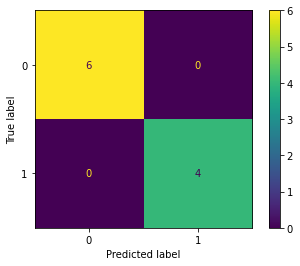

In [27]:
print(y_test.shape)
cm = confusion_matrix(y_test.iloc[:10],y_test_pred,normalize=None)
ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=pipe.named_steps['featuresel'].estimator_.classes_).plot()
plt.show()

In [28]:
# we save the pipeline using joblib 
joblib.dump(pipe,'chocolate-pipe.joblib')

['chocolate-pipe.joblib']